In [17]:
import pymc3 as pm
import numpy as np

In [2]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 1.0)
    data_generator = pm.Poisson('data_generator', parameter)

In [3]:
with model:
    data_plus_one = data_generator + 1

In [4]:
parameter.tag.test_value

array(0.69314718)

All PyMC3 variables have an initial value (test value).

In [5]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


The `test_Value` is used only for the model, as the starting point for sampling if no other start is specified. It will not change as a result of sampling. This initial state can be changed at variable creation by specifying a value for the `testval` parameter.

In [8]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 1.0, testval=0.5)
    
parameter.tag.test_value

array(0.5)

PyMC3 is concerned with two types of programming variables: stochastic and deterministic.

Stochastic variables are variables that are not deterministic. Even if you knew all of the variables' parameters and components, it would still be random. INcluded in this category are instances of classes `Possion`, `DiscreteUniform`, and `Exponential`. 

**Initializiing Stochastic Variables**

Initializing a random variable requires a `name` argument, plus additional parameters that are class specific. For example:

In [10]:
with pm.Model() as model:
    some_variable = pm.DiscreteUniform('discrete_uniform_var', 0, 4)

In [11]:
??pm.DiscreteUniform

Init signature: pm.DiscreteUniform(name, *args, **kwargs)
Source:        
class DiscreteUniform(Discrete):
    R"""
    Discrete uniform distribution.
    The pmf of this distribution is

    .. math:: f(x \mid lower, upper) = \frac{1}{upper-lower+1}

    .. plot::

        import matplotlib.pyplot as plt
        import numpy as np
        import scipy.stats as st
        plt.style.use('seaborn-darkgrid')
        ls = [1, -2]
        us = [6, 2]
        for l, u in zip(ls, us):
            x = np.arange(l, u+1)
            pmf = [1.0 / (u - l + 1)] * len(x)
            plt.plot(x, pmf, '-o', label='lower = {}, upper = {}'.format(l, u))
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        plt.ylim(0, 0.4)
        plt.legend(loc=1)
        plt.show()

    ========  ===============================================
    Support   :math:`x \in {lower, lower + 1, \ldots, upper}`
    Mean      :math:`\dfrac{lower + upper}{2}`
    Variance  :math:`\dfrac{(upper - 

The `name` attribute is used to retrieve the psoterior distribution later in the analysis, so it is best to use a descriptive name. 

For multivariable problems we can use the `shape` keyword in the call to a stochastic variable to create an array of independent variables. The array behaves like a `numpy` array when used like one.

**Deterministic Variables**

WE can create a deterministic variable similarly to how we create a stochastic variable. We simply call the `Deterministic` class in PyMC3 and pass in the function that we desire.

`deterministic_variable = pm.Deterministic("deterministic variable", some_function_of_variables)`

Inside a `deterministic` variable, the stochastic variables passed in behave like scalars or NumPy arrays (if multivariable). We can do whatever we want with them as long as the dimensions match up in our calculations.
```
def subtract(x, y):
    return x - y

stochastic_1 = pm.Uniform("U_1", 0, 1)
stochastic_2 = pm.Uniform("U_2", 0, 1)

det_1 = pm.Deterministic("Delta", subtract(stochastic_1, stochastic_2))
```

Let's write some PyMC3 code that involves `thano` calculations.

In [12]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical('assignment', p)

Here we use `theano`'s `stack()` function in the same way we would use one of NumPy's stacking functions: to combine our 2 separate variables, `p1` and `p2`, into a vector with 2 elements. The stochastic `categorical` variable does not udnerstand what we mean if we pass in a `NumPy` array of `p1` and `p2` to it because they are both `theano` variables. Stacking them like this combines them into one `theano` variable that we can use as the complementary pair of probabilities for our two categories. 

### Including Observations in the Model

What does my prior distribution of $\lambda_1$ look like?

In [14]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

C:\Users\andre\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


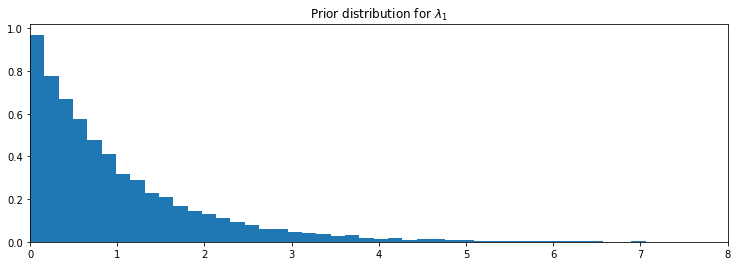

In [15]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
figsize(12.5, 4)


samples = lambda_1.random(size=20000)
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

PyMC3 stochastic variables have a keyboard argument `observed`. The keyword `observed` has a very simple role: fix the variable's current value to be the given data.

In [18]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


This is how we include data into our models: initializing a stochastic variable to have a fixed value.

# Modeling Approaches

A good starting through to Bayesian modeling is to think about how your data might have been generated. 

(Text message example)

1. We started by thinking "what is the best random variable to describe this count data?". A poisson random variable is a good candidate because it can represent count data. So we model the number of SMS messages received as as a sample from a Poisson distribution. 

2. Next we think "assuming SMS messages are Poisson distributed, what do I need for a Poisson distribution?". Well, a Poisson distribution has a parameter $\lambda$.

3. Do we know $\lambda$? No. In fact, we have a suspicion there are two lambda values, one for the earlier behavior and one for the later. We don't know when the behavior switches though, but call the switch point $\tau$. 

4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. The exponential distribution has a parameter too, call it $\alpha$.

5. Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$, we don't really have any strong beliefs about $\alpha$, so it's best to stop there.

What is a good value for $\alpha$ then? We think that the lambdas are between 10-30, so if we set $\alpha$ really low (which corresponds to a larger probability for higher values) we are not reflecting our prior well. Similarly, a too-high alpha misses our prior beliefs as well. A good idea for $\alpha$ as to reflect our belief is to set the value so that the mean of lambda, given $\alpha$, is equal to our observed mean.

6. We have no expert opinion on when $\tau$ might have occurred, so we will suppose it is from a discrete uniform distribution over the entire timespan.

# An Algorithm for Human Deceit

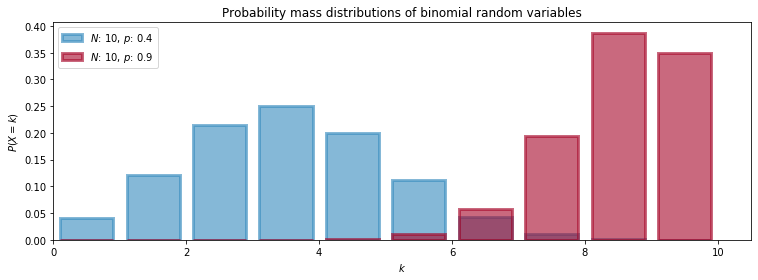

In [20]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

#### Cheating Amongst Students

We will use the binomial distribution to determine the frequency of students cheating during an exam. If we let $N$ be the total number of students who toko the exam, and assuming each student is interviewed post-exam (answering without consequence), we will receive integer `X` "Yes I did cheat" answers. We then find the posterior distribution of `p`, given `N`, some specified prior on `p`, and observed data `X`. 

This is an absurd model. No student, even with a free-pass against punishment, would admit to cheating. What we need is a better algorithm to ask students if they had cheated. Ideally the algorithm should encourage individuals to be honest while preseving privacy.
```
In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers.
```

Suppose 100 students are being surveryed for cheating, and we wish to find `p`, the proportion of cheaters. There are a few ways we can model this in PyMC3. We'll start with the most explicit way and later show a simplified version. 

In [27]:
import pymc3 as pm

N = 100
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)

In [28]:
with model:
    true_answers = pm.Bernoulli('truths', p, shape=N, testval=np.random.binomial(1, 0.5, N))

If we carry out the algorithm, the next step that occurs is the first coin-flip each student makes. This can be modeled again by sampling 100 Bernoulli random variables with p=1/2. 

In [29]:
with model:
    first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
print(first_coin_flips.tag.test_value)

[1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 1
 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0
 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1]


In [30]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

Using these variables, we can return a possible realization of the observed proportion of `yes` responses. We do this using a PyMC3 `deterministic` variable.

In [31]:
import theano.tensor as tt

with model:
    val = first_coin_flips * true_answers + (1 - first_coin_flips) * second_coin_flips
    observed_proportion = pm.Deterministic('observed_proportion', tt.sum(val)/float(N))

In [32]:
observed_proportion.tag.test_value

array(0.41999999)

Next, we need a dataset. After perming our coin-flipped interviews the researchers received 35 "yes" responded. If there were truly no cheaters, we should expect, on average, 1/4 of all responses being "yes". If all students cheated we'd expect approximately 3/4 responses to be "yes". 

The researchers observe a Binomial random variable, with N = 100, p = observed_proportion with value = 35:

In [33]:
X = 35

with model:
    observations = pm.Binomial('obs', N, observed_proportion, observed=X)

In [34]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████| 162000/162000 [16:47<00:00, 160.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


C:\Users\andre\anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


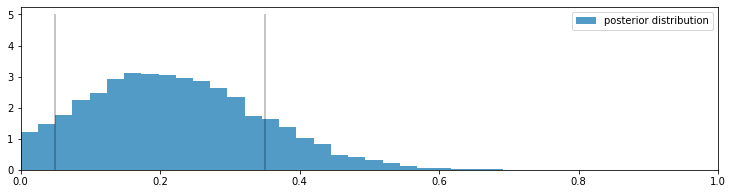

In [35]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

## Alternative PyMC3 Model

Given a value for p, which from our god-like position we know), we can find the probability the student will answer yes:

P(Yes) = P(Heads First Flip)*P(Cheater) + P(Tails on First Coin) * P(Heads on Second Coin)  
       = p/2 + 1/4
       
Thus, we can create a deterministic function.

In [36]:
with pm.Model() as model:
    p = pm.Uniform('freq_cheating', 0, 1)
    p_skewed = pm.Deterministic('p_skewed', 0.5*p + 0.25)

In [37]:
with model:
    yes_responses = pm.Binomial('number_cheaters', 100, p_skewed, observed=35)

In [38]:
with model:
    # To Be Explained in Chapter 3!
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    burned_trace = trace[2500:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [freq_cheating]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████| 102000/102000 [00:29<00:00, 3485.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


C:\Users\andre\anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


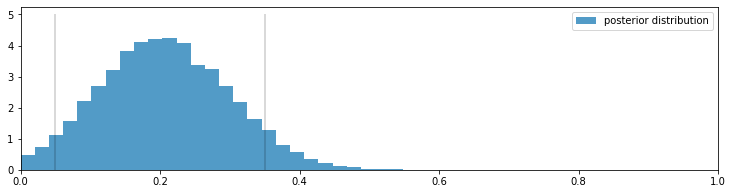

In [39]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

## More PyMC3 Tricks

Protip: Arrays of PyMC3 variables

There is no reason why we cannot store multiple heterogeneous PyMC3 variables in a Numpy array. Just remember to set the dtype of the array to object upon initialization. For example:

In [40]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_%i' % i, (i+1.0)**2)

In [41]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

OSError: data/challenger_data.csv not found.